In [1]:
import os
os.environ["WEBBPSF_PATH"] = '../webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = '../webbpsf-data'
os.environ["PYSYN_CDBS"] = "../cdbs"

from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

#### Loading Files

In [2]:
import pandas as pd

# GPI Image Initial Parameter Reference

# Name             Radius   Inclination  Position Angle Distance  Knots                                                  
# hd145560_H_pol    85.3         43.9        221.5        120.44      7
# hd146897_H_pol    85.0         84.0        293.9        131.50      9
# ceant_H_pol       29.8         13.1        271.0         34.03      7
# hd111520_H_pol    81.0         88.0        165.0        108.94      7
# hd115600_H_pol    46.0         80.0         27.5        109.62      7
# hd129590_H_pol    66.9         75.7        121.7        136.04      9
# hd117214_H_pol    60.2         71.0        359.8        107.61     11
# hd35841_H_pol     60.3         84.9        345.8        103.68      7
# hd30447_H_pol     83.0         83.0         32.3         80.54      7
# hd32297_H_pol     98.4         88.4         47.9        132.79     13
# hd110058_H_pol    39.0         84.0        335.0        129.98      5
# hd111161_H_pol    72.4         62.1        263.2        109.43      7
# hd157587_H_pol    79.0         70.0        127.0        100.51      7
# hr4796a_H_pol     78.5         76.5         26.1         72.78     11
# hd131835_H_pol   107.7         75.1         61.4        133.65      7
# hd106906_H_pol    72.3         84.6        104.2        103.33      8
# hd114082_H_pol    30.7         83.3        285.7         95.65      5
# hd191089_H_pol    43.9         59.0         70.0         50.13     13
# hd156623_H_pol    80.2         34.9        280.9        111.75     11

row = {'Name': 'hr4796a_H_pol', 'Radius': 78.5, 'Inclination': 76.5, "Position Angle": 26.1, "Distance": 72.78, "Knots": 7,}

In [3]:
import sys
sys.path.append('..')

### Processing Fits File

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
Could not import CuPy. Setting: use_gpu=False (i.e., using CPU operations).
Filename: ../test_images/hr4796a_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     391   ()      
  1  SCI           1 ImageHDU       135   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

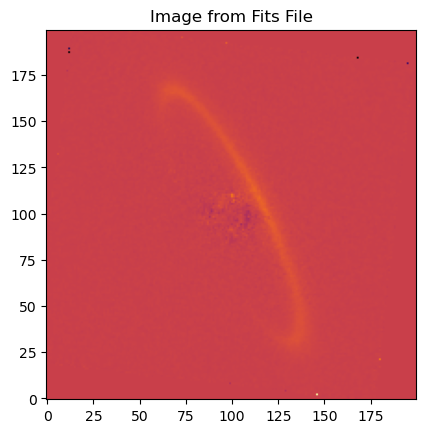

In [4]:
from optimization.optimize_framework import OptimizeUtils

fits_image_filepath = "../test_images/" + row['Name'] + ".fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [5]:
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

### Getting Optimal Fit

In [6]:

target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:], bounds=(40, 240, 40, 240))
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]), bounds=(40, 240, 40, 240)) #, outlier_pixels=[(57, 68)]))

In [7]:
start_disk_params = Parameter_Index.disk_params.copy()
start_spf_params = InterpolatedUnivariateSpline_SPF.params.copy()
start_psf_params = EMP_PSF.params.copy()
start_stellar_psf_params = LinearStellarPSF.params.copy()
start_misc_params = Parameter_Index.misc_params.copy()

start_disk_params = Parameter_Index.disk_params.copy()
start_disk_params['sma'] = row["Radius"]
start_disk_params['inclination'] = row["Inclination"]
start_disk_params['position_angle'] = row["Position Angle"]

start_spf_params['num_knots'] = 7 # int(row["Knots"])

start_misc_params['distance'] = row["Distance"]
start_misc_params['nx'] = 200
start_misc_params['ny'] = 200

start_disk_params['x_center'] = start_misc_params['nx']/2
start_disk_params['y_center'] = start_misc_params['ny']/2

opt = Optimizer(start_disk_params, start_spf_params, start_psf_params, start_misc_params,
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

opt.inc_bound_knots() # call this method only if you have a good predifined inclination, otherwise don't use it
opt.initialize_knots(target_image)

print(opt.log_likelihood(target_image, err_map))

-130804.31533045582


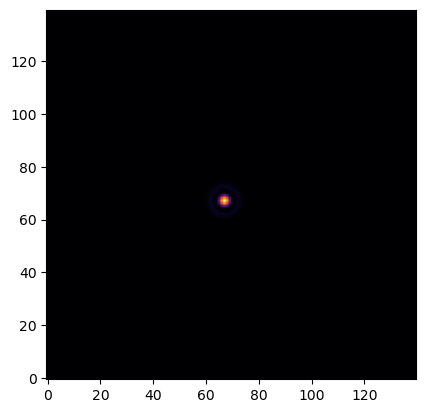

In [8]:
plt.imshow(EMP_PSF.img, origin='lower', cmap='inferno')

In [9]:
opt.get_gradient(['sma', 'alpha_in'], target_image, err_map)

array([-561.96548015, -265.52622392])

In [24]:
%timeit opt.log_likelihood(target_image, err_map)

5.02 ms ± 4.07 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit opt.get_gradient(['sma', 'alpha_in'], target_image, err_map)

63.2 ms ± 720 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Initial Guess, Log-Likelihood: -130804.31533045582')

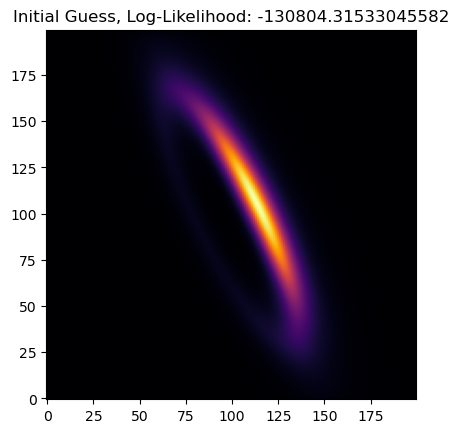

In [12]:
plt.imshow(opt.get_model(), origin='lower', cmap='inferno')
plt.title("Initial Guess, Log-Likelihood: " + str(opt.log_likelihood(target_image, err_map)))

In [13]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 5, 'alpha_out': -5, 'sma': 78.5, 'e': 0.0, 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.5, 'position_angle': 26.1, 'x_center': 100.0, 'y_center': 100.0, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.97236992, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.97236992, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([9.55356017, 2.99389941, 1.56868337, 1.        , 0.70763107,
       0.53436262, 0.42183294], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(3032.54671768, dtype=float64)}


In [14]:
# Running optimization method
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [200, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

opt.scipy_bounded_optimize(fit_keys, bounds, logscaled_params, array_params, target_image, err_map, disp_soln=True, iters = 2000)
optimal_image = opt.get_model()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 98104.7671921626
        x: [ 1.200e+01 -1.435e+01 ... -1.314e+00  0.000e+00]
      nit: 32
      jac: [-3.077e+02 -1.346e+02 ...  4.002e+00  8.278e+03]
     nfev: 880
     njev: 55
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>


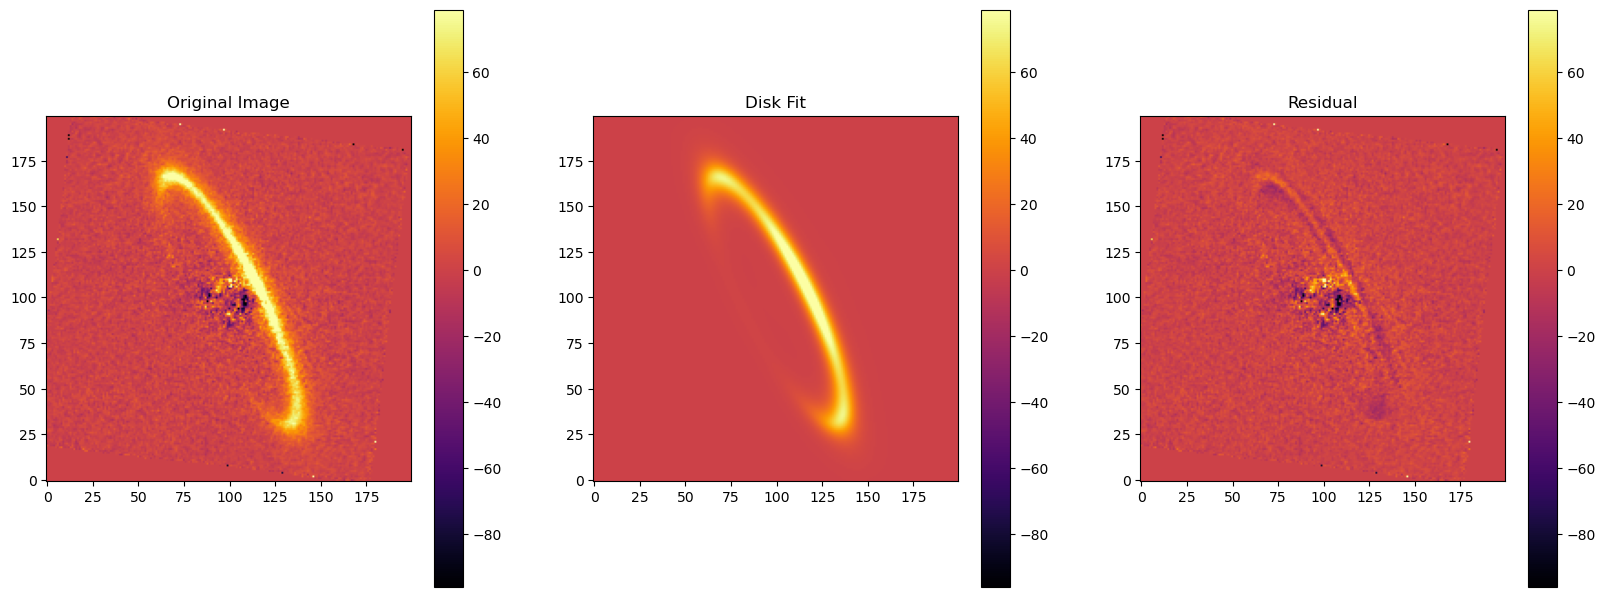

In [15]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)

In [16]:
opt.scale_spline_to_fixed_point(0, 1)
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': np.float64(12.00198044928163), 'alpha_out': np.float64(-14.348957971231895), 'sma': np.float64(78.27438751842227), 'e': np.float64(0.0), 'ksi0': 3.0, 'gamma': 2.0, 'beta': 1.0, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': np.float64(75.72275021491906), 'position_angle': np.float64(26.80136298401289), 'x_center': np.float64(101.40233968478356), 'y_center': np.float64(100.58466163506047), 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'backscatt_bound': Array(-0.97236992, dtype=float64, weak_type=True), 'forwardscatt_bound': Array(0.97236992, dtype=float64, weak_type=True), 'num_knots': 7, 'knot_values': Array([3.10907741, 1.47270666, 1.33141213, 1.        , 0.59535073,
       0.2045443 , 0.03653791], dtype=float64)}
PSF Params: {'scale_factor': 1.0, 'offset': 1.0}
Stellar PSF Params: None
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 200, 'ny': 200, 'halfNbSlices': 25, 'flux_scaling': Array(22314.5529703, dtype=float64)}


## Running MCMC

In [17]:
# For MCMC, spline values are log scaled, the optimizer class passes them in as log(spf_params) and they are exponated in the lambda expression, this evens out the markov chains
# helping MCMC work better

fit_keys = ['alpha_in', 'alpha_out', 'sma', 'inclination', 'position_angle', 'x_center', 'y_center', 'knot_values', 'e']
logscaled_params = ['knot_values']
array_params = ['knot_values']
bounds = ([0.1, -15, 0, 0, 0, 90, 90, np.zeros(7), 0],
          [200, -0.1, 150, 180, 400, 110, 110, 1e4*np.ones(7), 1])

mc_model = opt.mcmc(fit_keys, logscaled_params, array_params, target_image, err_map, bounds, nwalkers=100, niter=100, burns=20)

Overwriting the previous backend...
Running burn-in...


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Running production...


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


In [18]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.get_model()

Text(0.5, 1.0, 'Post MCMC')

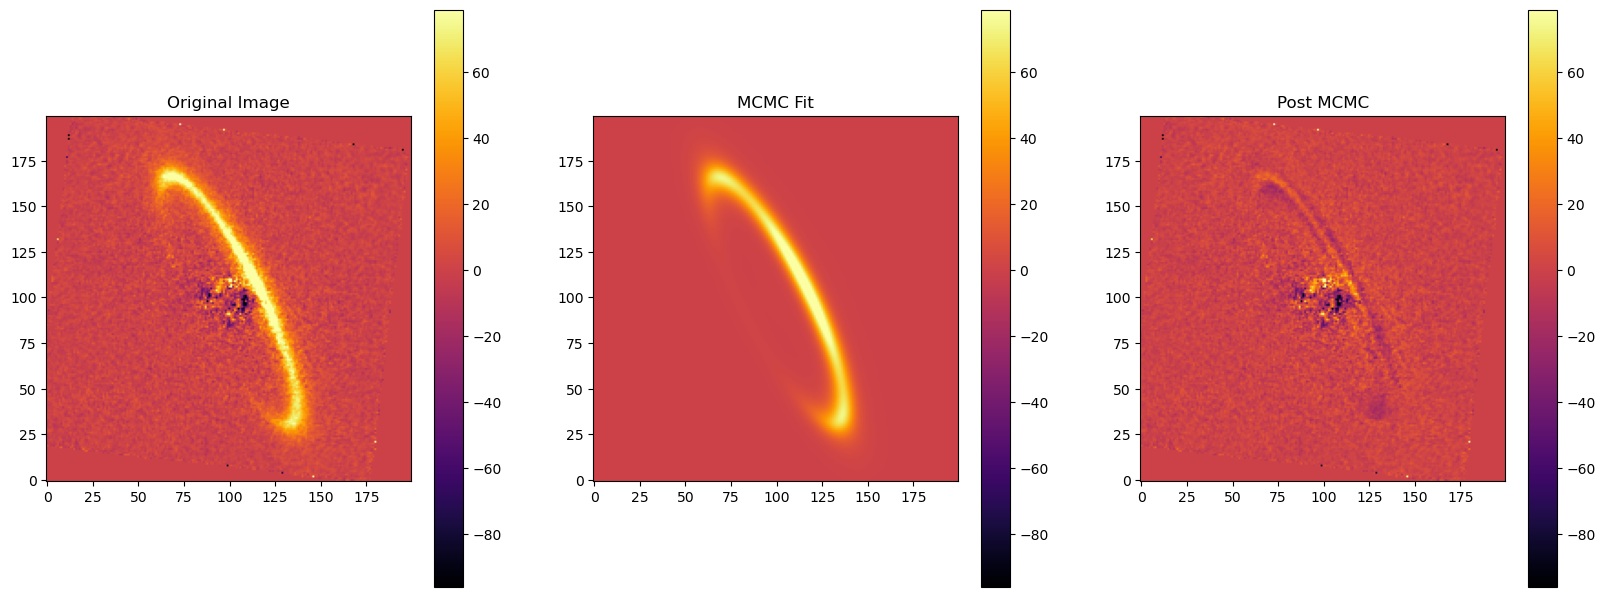

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno')
axes[1].set_title("MCMC Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(vmin, vmax)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(vmin, vmax)
plt.title("Post MCMC")

### Plotting MCMC Results

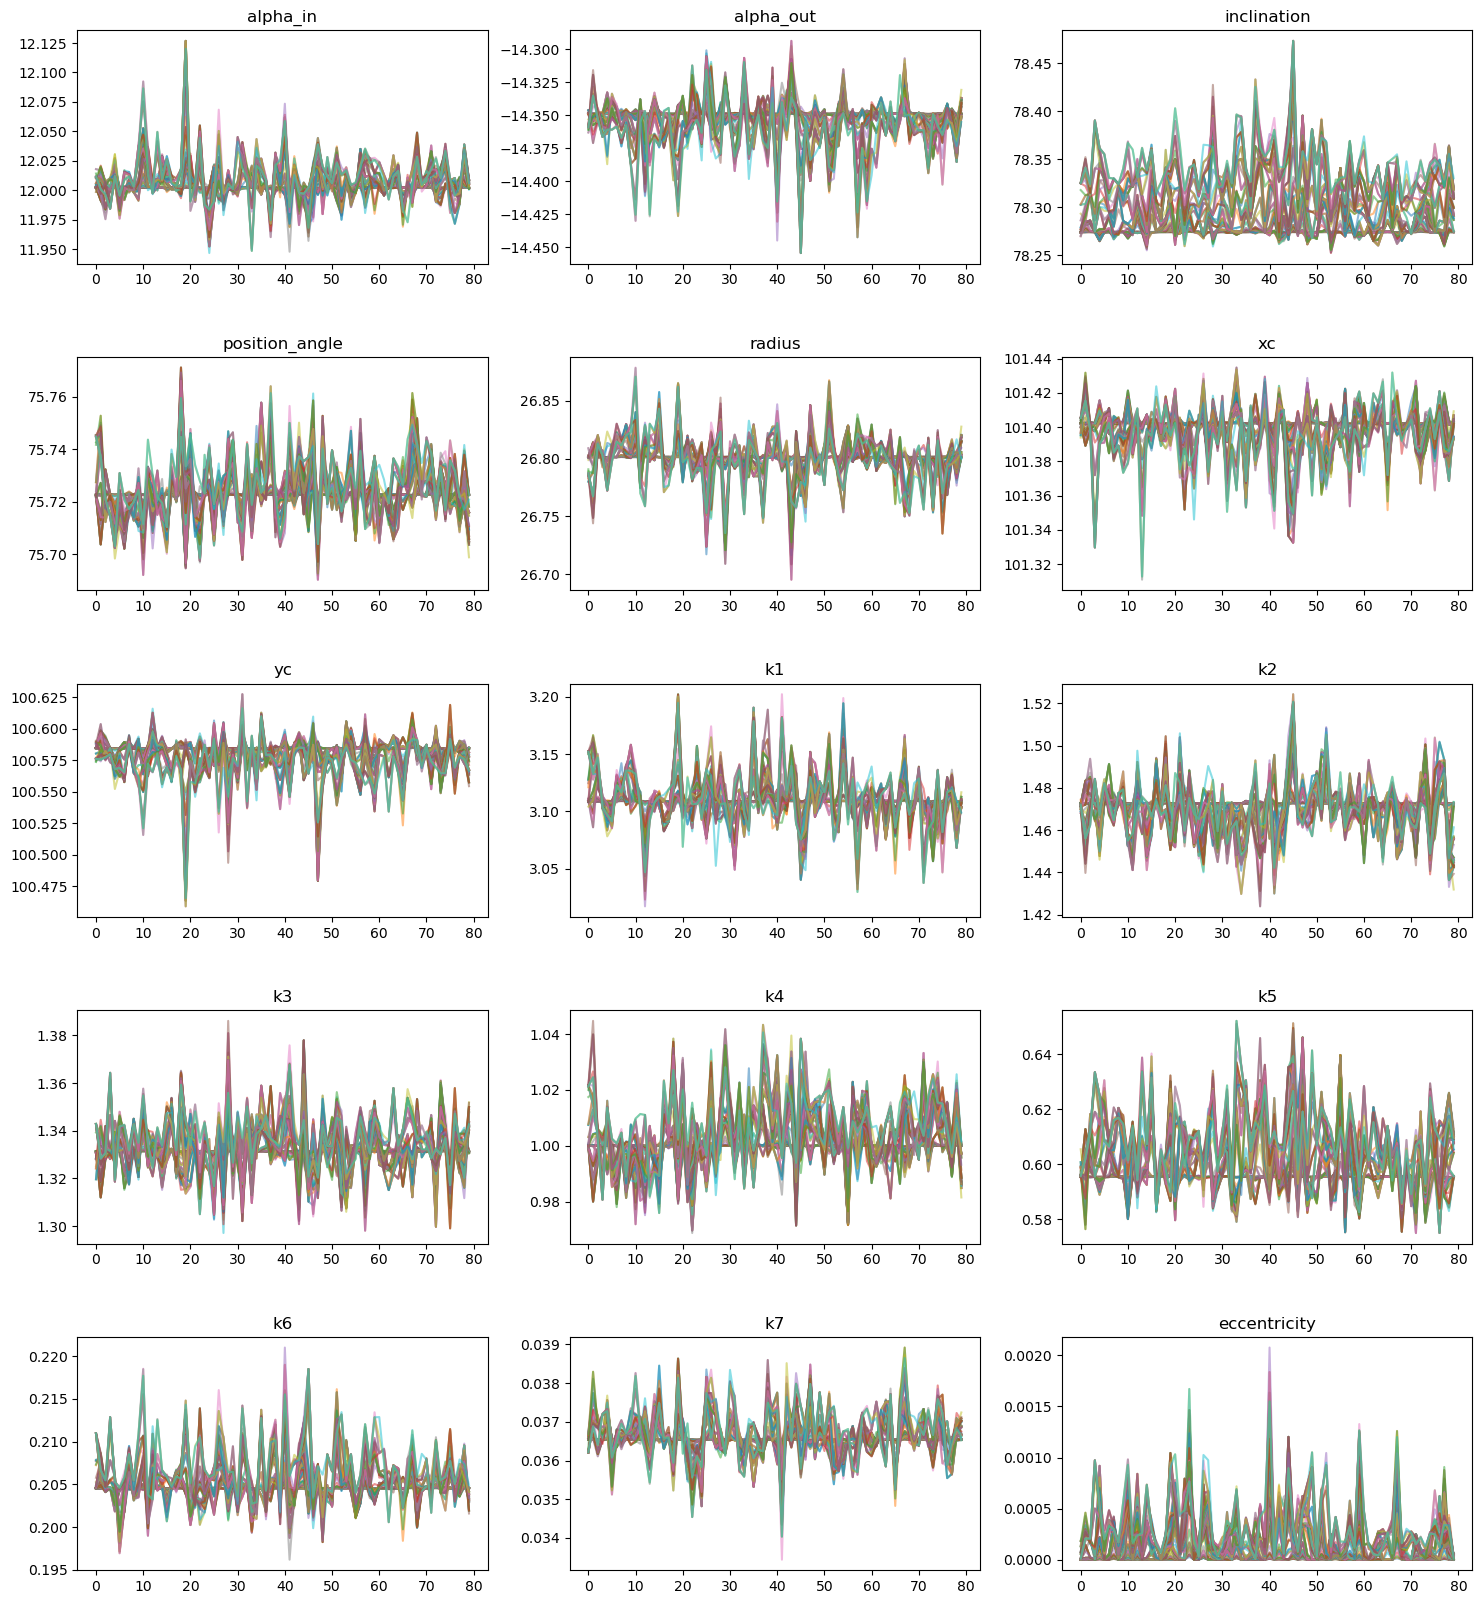

In [20]:
labels = ['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
labels.append('eccentricity')
mc_model.plot_chains(labels, scaled = True)

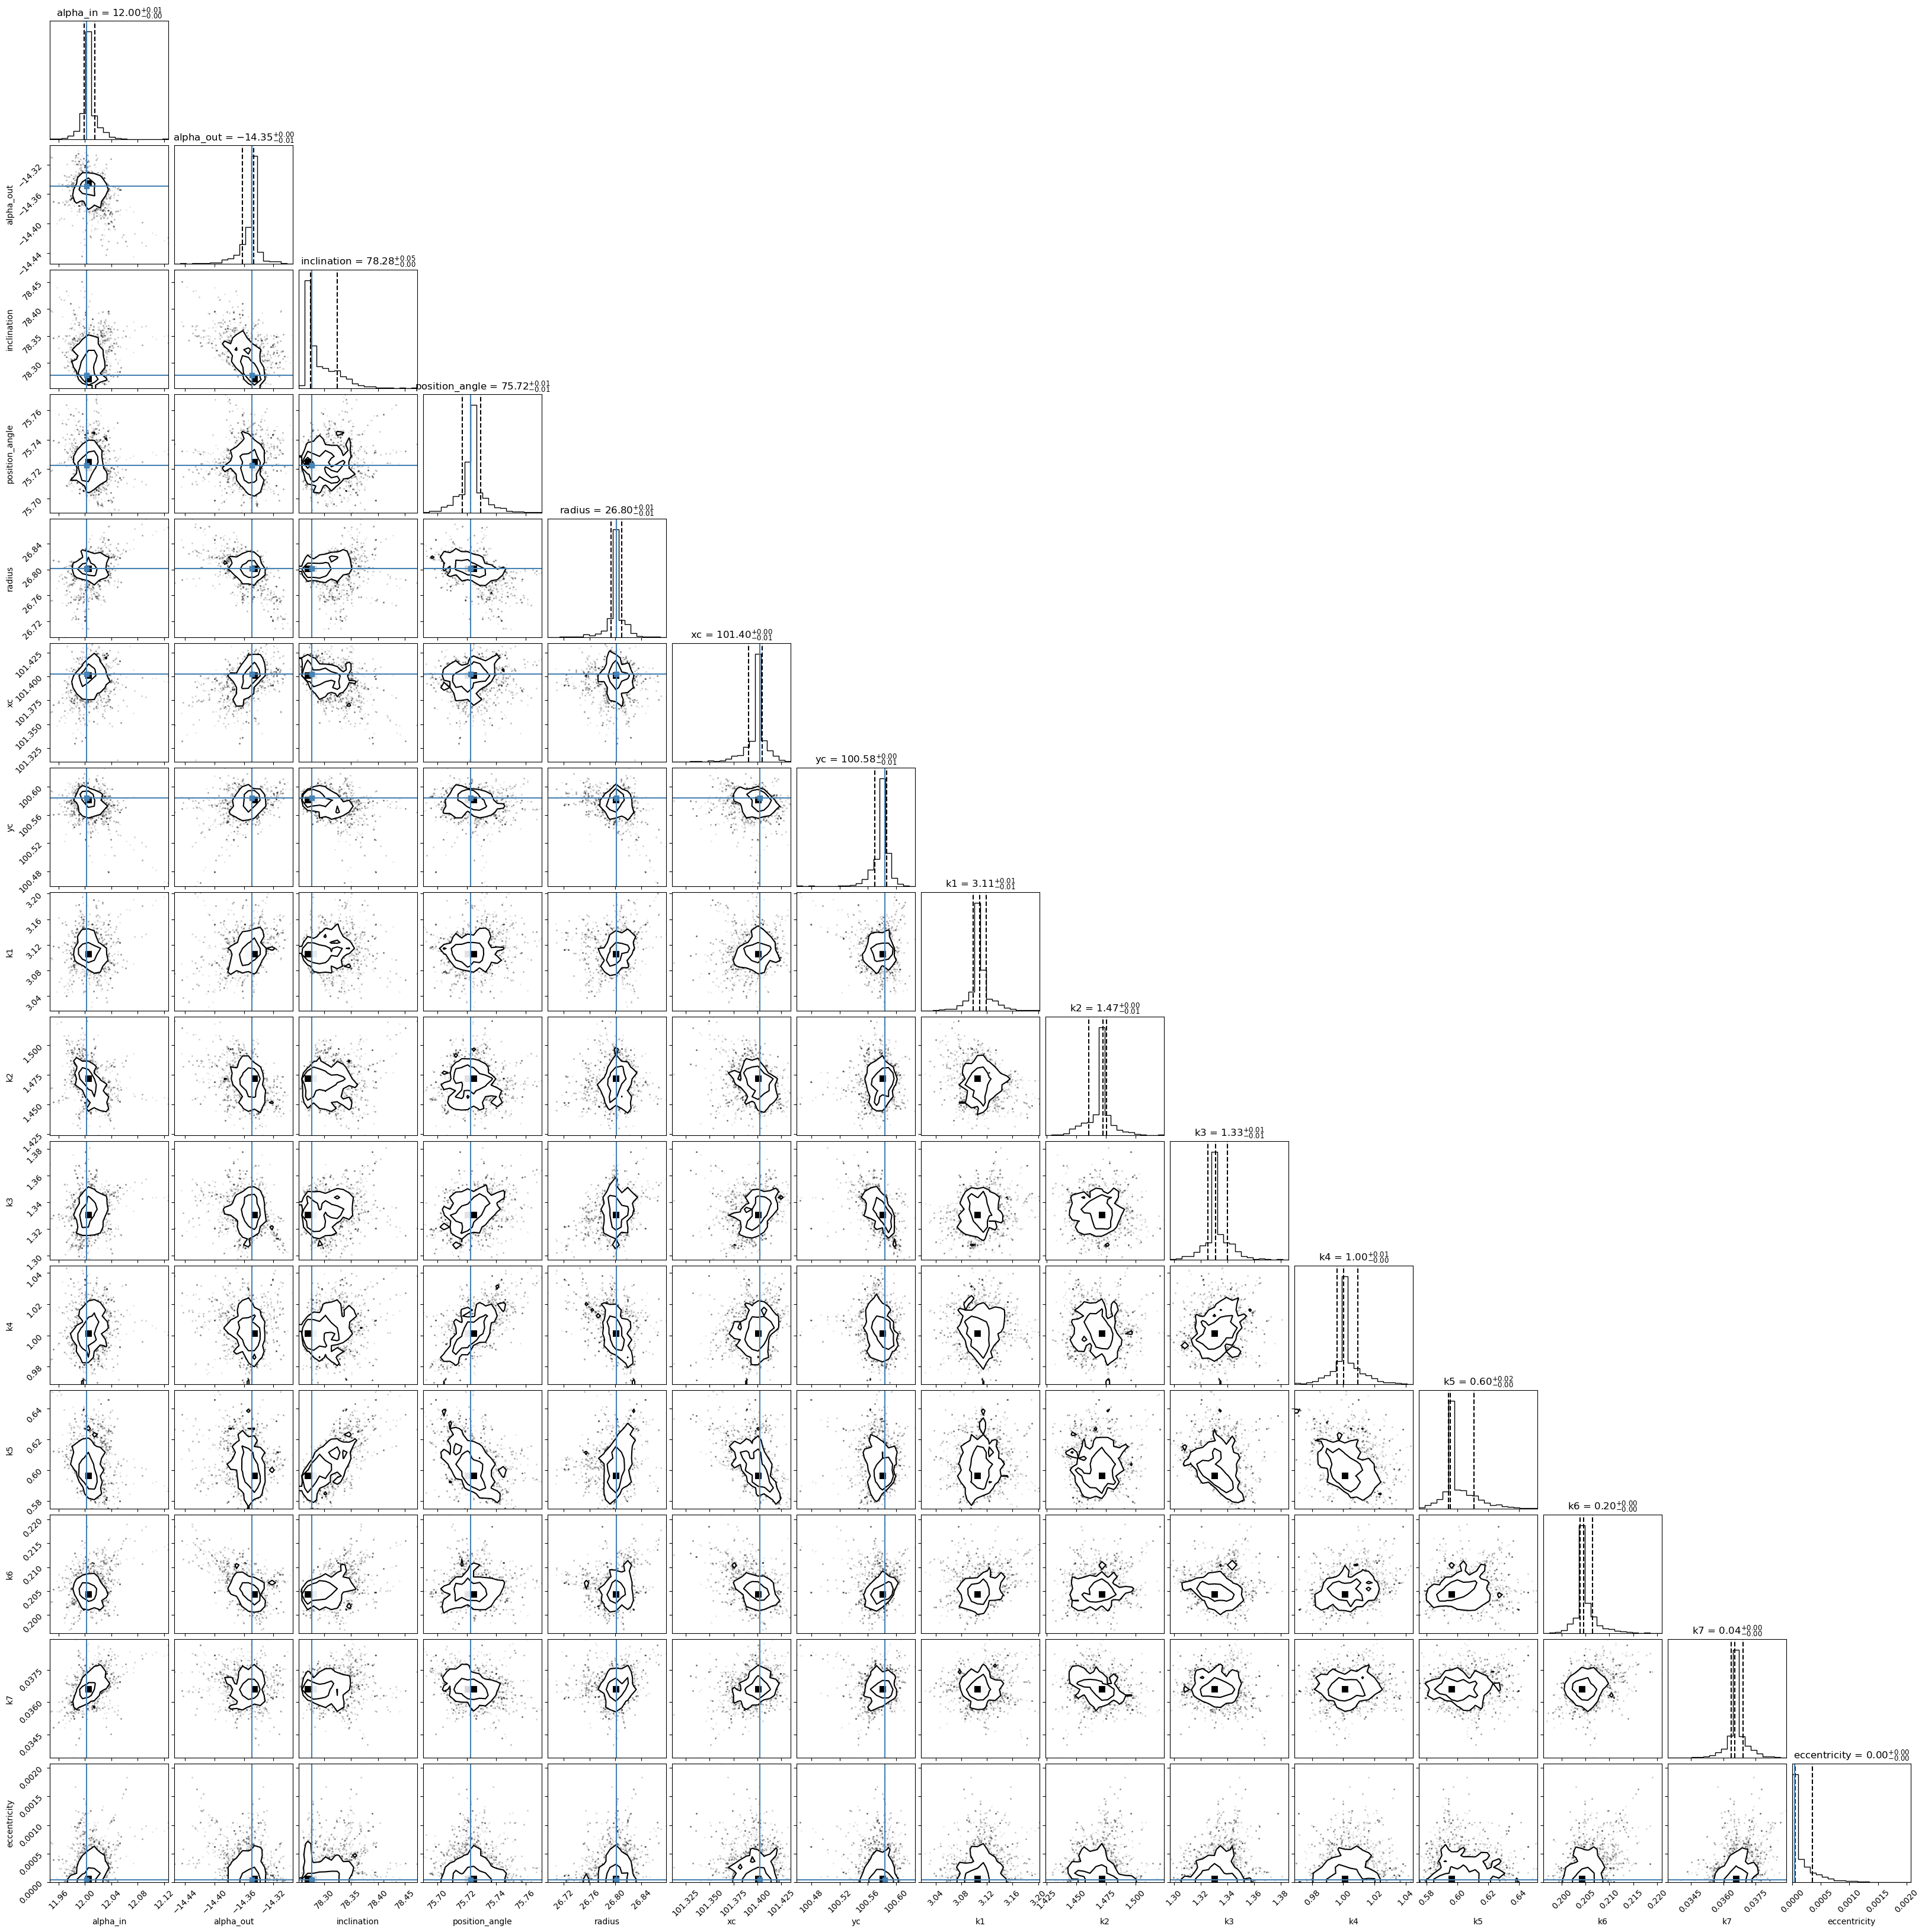

In [21]:
mc_model.show_corner_plot(labels, truths=mc_soln, scaled = True, quiet = True)

In [22]:
print(mc_model.get_theta_median(scaled = True))
print(labels)

[ 1.20020055e+01 -1.43489789e+01  7.82765083e+01  7.57227496e+01
  2.68013638e+01  1.01402318e+02  1.00584641e+02  3.10907871e+00
  1.47266361e+00  1.33141426e+00  1.00000705e+00  5.95501996e-01
  2.04546941e-01  3.65381511e-02  4.48762532e-05]
['alpha_in', 'alpha_out', 'inclination', 'position_angle', 'radius', 'xc', 'yc', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'eccentricity']
